# Comparison: Trained Steering Vectors vs Activation Vectors (CAA)

This notebook compares two methods for steering model behavior:
1. **Trained Steering Vectors**: Trained with cross entropy loss on target transcripts from 0 init
2. **Activation Vectors (CAA)**: Contrastive Activation Addition - simple mean differences
   - Roles: `pos_3 - default_1` at layer 31 (original), evaluated at layer 31
   - Traits: `pos_neg_50` at layer 31 (original), evaluated at layer 31

Both are evaluated as classifiers by projecting hidden states and fitting only scale+offset.

In [11]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

## Load Results

In [12]:
def load_results(result_dir):
    """Load all evaluation results from a directory."""
    results = []
    result_path = Path(result_dir)
    
    for json_file in result_path.glob("*.json"):
        if json_file.name == "eval_summary.json":
            continue
            
        with open(json_file) as f:
            data = json.load(f)
            
        # Extract key metrics
        result = {
            "dataset": data["dataset"],
            "dataset_type": data["dataset_type"],
            "n_records": data.get("n_records"),
            "n_positive": data.get("n_positive"),
        }
        
        # Steering vector metrics
        if "steering_vector" in data and "metrics" in data["steering_vector"]:
            steering = data["steering_vector"]["metrics"]
            result["steering_test_roc_auc"] = steering.get("test_roc_auc")
            result["steering_test_accuracy"] = steering.get("test_accuracy")
            result["steering_test_f1"] = steering.get("test_f1")
            result["steering_train_roc_auc"] = steering.get("train_roc_auc")
        
        # Activation vector metrics
        if "activation_vector" in data and "metrics" in data["activation_vector"]:
            activation = data["activation_vector"]["metrics"]
            result["activation_test_roc_auc"] = activation.get("test_roc_auc")
            result["activation_test_accuracy"] = activation.get("test_accuracy")
            result["activation_test_f1"] = activation.get("test_f1")
            result["activation_train_roc_auc"] = activation.get("train_roc_auc")
        else:
            result["activation_test_roc_auc"] = None
            result["activation_test_accuracy"] = None
            result["activation_test_f1"] = None
            result["activation_train_roc_auc"] = None
            
        results.append(result)
    
    return pd.DataFrame(results)

# Load both roles and traits
roles_df = load_results("/workspace/classifier_eval_comprehensive/")
traits_df = load_results("/workspace/classifier_eval_comprehensive_traits/")

# Combine
df = pd.concat([roles_df, traits_df], ignore_index=True)

print(f"Loaded {len(roles_df)} roles and {len(traits_df)} traits")
print(f"Total: {len(df)} evaluations")
print(f"\nWith both vectors: {df['activation_test_roc_auc'].notna().sum()}")
print(f"Steering only: {df['activation_test_roc_auc'].isna().sum()}")

Loaded 274 roles and 220 traits
Total: 494 evaluations

With both vectors: 494
Steering only: 0


In [13]:
df.head()

,dataset,dataset_type,n_records,n_positive,steering_test_roc_auc,steering_test_accuracy,steering_test_f1,steering_train_roc_auc,activation_test_roc_auc,activation_test_accuracy,activation_test_f1,activation_train_roc_auc
0,qwen-3-32b__role__zeitgeist,role,2014,814,0.825818,0.719603,0.683473,0.781748,0.977633,0.925558,0.910714,0.979120
1,qwen-3-32b__role__zealot,role,2348,1148,0.678659,0.614894,0.626804,0.648855,0.999873,0.991489,0.991266,0.998637
2,qwen-3-32b__role__writer,role,2035,835,0.685903,0.616708,0.561798,0.674451,0.772779,0.724816,0.676301,0.779204
3,qwen-3-32b__role__wraith,role,2389,1189,0.950018,0.882845,0.882845,0.933821,0.999790,0.993724,0.993684,0.999356
4,qwen-3-32b__role__workaholic,role,1982,782,0.653264,0.614610,0.583106,0.604888,0.989676,0.944584,0.931677,0.983142


## Summary Statistics

In [14]:
# Filter to cases where we have both vectors
df_both = df[df['activation_test_roc_auc'].notna()].copy()

print(f"Comparing {len(df_both)} datasets with both vectors\n")
print("=" * 60)

# Overall statistics
for dataset_type in ['role', 'trait']:
    subset = df_both[df_both['dataset_type'] == dataset_type]
    if len(subset) == 0:
        continue
        
    print(f"\n{dataset_type.upper()}S (n={len(subset)})")
    print("-" * 60)
    
    for method, col in [('Trained Steering', 'steering_test_roc_auc'), 
                        ('Activation (CAA)', 'activation_test_roc_auc')]:
        values = subset[col].dropna()
        print(f"\n{method}:")
        print(f"  Mean:   {values.mean():.4f}")
        print(f"  Median: {values.median():.4f}")
        print(f"  Std:    {values.std():.4f}")
        print(f"  Min:    {values.min():.4f}")
        print(f"  Max:    {values.max():.4f}")
    
    # Difference
    diff = subset['activation_test_roc_auc'] - subset['steering_test_roc_auc']
    print(f"\nDifference (Activation - Steering):")
    print(f"  Mean:   {diff.mean():.4f}")
    print(f"  Median: {diff.median():.4f}")
    print(f"  Std:    {diff.std():.4f}")
    print(f"\nActivation wins: {(diff > 0).sum()} ({100 * (diff > 0).sum() / len(diff):.1f}%)")
    print(f"Steering wins:   {(diff < 0).sum()} ({100 * (diff < 0).sum() / len(diff):.1f}%)")
    print(f"Ties:            {(diff == 0).sum()}")
    
    # Paired t-test
    t_stat, p_value = stats.ttest_rel(
        subset['activation_test_roc_auc'],
        subset['steering_test_roc_auc']
    )
    print(f"\nPaired t-test: t={t_stat:.3f}, p={p_value:.2e}")

Comparing 494 datasets with both vectors


ROLES (n=274)
------------------------------------------------------------

Trained Steering:
  Mean:   0.7441
  Median: 0.7565
  Std:    0.1485
  Min:    0.4427
  Max:    0.9891

Activation (CAA):
  Mean:   0.9058
  Median: 0.9517
  Std:    0.1080
  Min:    0.4740
  Max:    1.0000

Difference (Activation - Steering):
  Mean:   0.1617
  Median: 0.1514
  Std:    0.0966

Activation wins: 272 (99.3%)
Steering wins:   2 (0.7%)
Ties:            0

Paired t-test: t=27.699, p=2.81e-81

TRAITS (n=220)
------------------------------------------------------------

Trained Steering:
  Mean:   0.7696
  Median: 0.7689
  Std:    0.1620
  Min:    0.3423
  Max:    1.0000

Activation (CAA):
  Mean:   0.8829
  Median: 0.9425
  Std:    0.1469
  Min:    0.3870
  Max:    1.0000

Difference (Activation - Steering):
  Mean:   0.1133
  Median: 0.1110
  Std:    0.1961

Activation wins: 171 (77.7%)
Steering wins:   49 (22.3%)
Ties:            0

Paired t-test: t=8.571,

## Visualizations

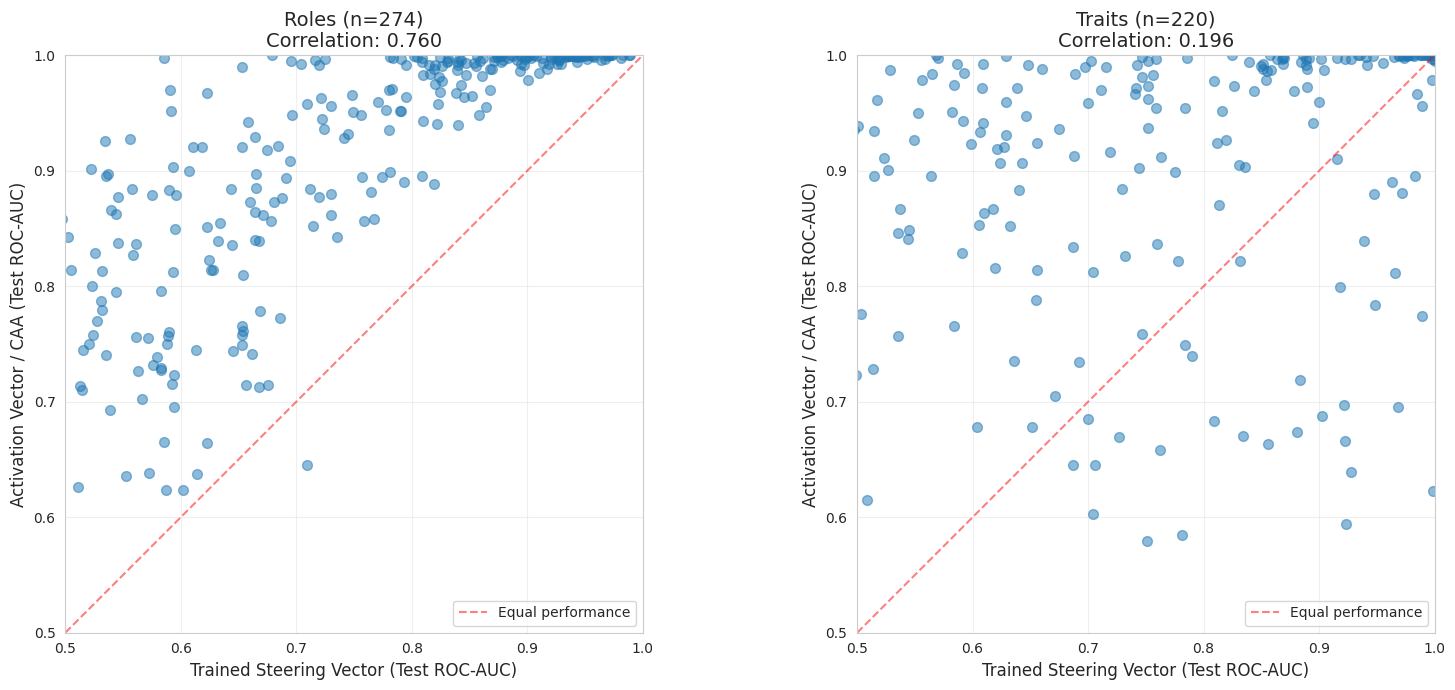

In [15]:
# Scatter plot: Steering vs Activation
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for idx, dataset_type in enumerate(['role', 'trait']):
    ax = axes[idx]
    subset = df_both[df_both['dataset_type'] == dataset_type]
    
    if len(subset) == 0:
        ax.text(0.5, 0.5, f'No {dataset_type} data yet', 
                ha='center', va='center', transform=ax.transAxes)
        continue
    
    # Scatter
    ax.scatter(subset['steering_test_roc_auc'], 
               subset['activation_test_roc_auc'],
               alpha=0.5, s=50)
    
    # Diagonal line (equal performance)
    lims = [0.5, 1.0]
    ax.plot(lims, lims, 'r--', alpha=0.5, label='Equal performance')
    
    # Correlation
    corr = subset['steering_test_roc_auc'].corr(subset['activation_test_roc_auc'])
    
    ax.set_xlabel('Trained Steering Vector (Test ROC-AUC)', fontsize=12)
    ax.set_ylabel('Activation Vector / CAA (Test ROC-AUC)', fontsize=12)
    ax.set_title(f'{dataset_type.capitalize()}s (n={len(subset)})\nCorrelation: {corr:.3f}', 
                 fontsize=14)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('/workspace/steering_vs_activation_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

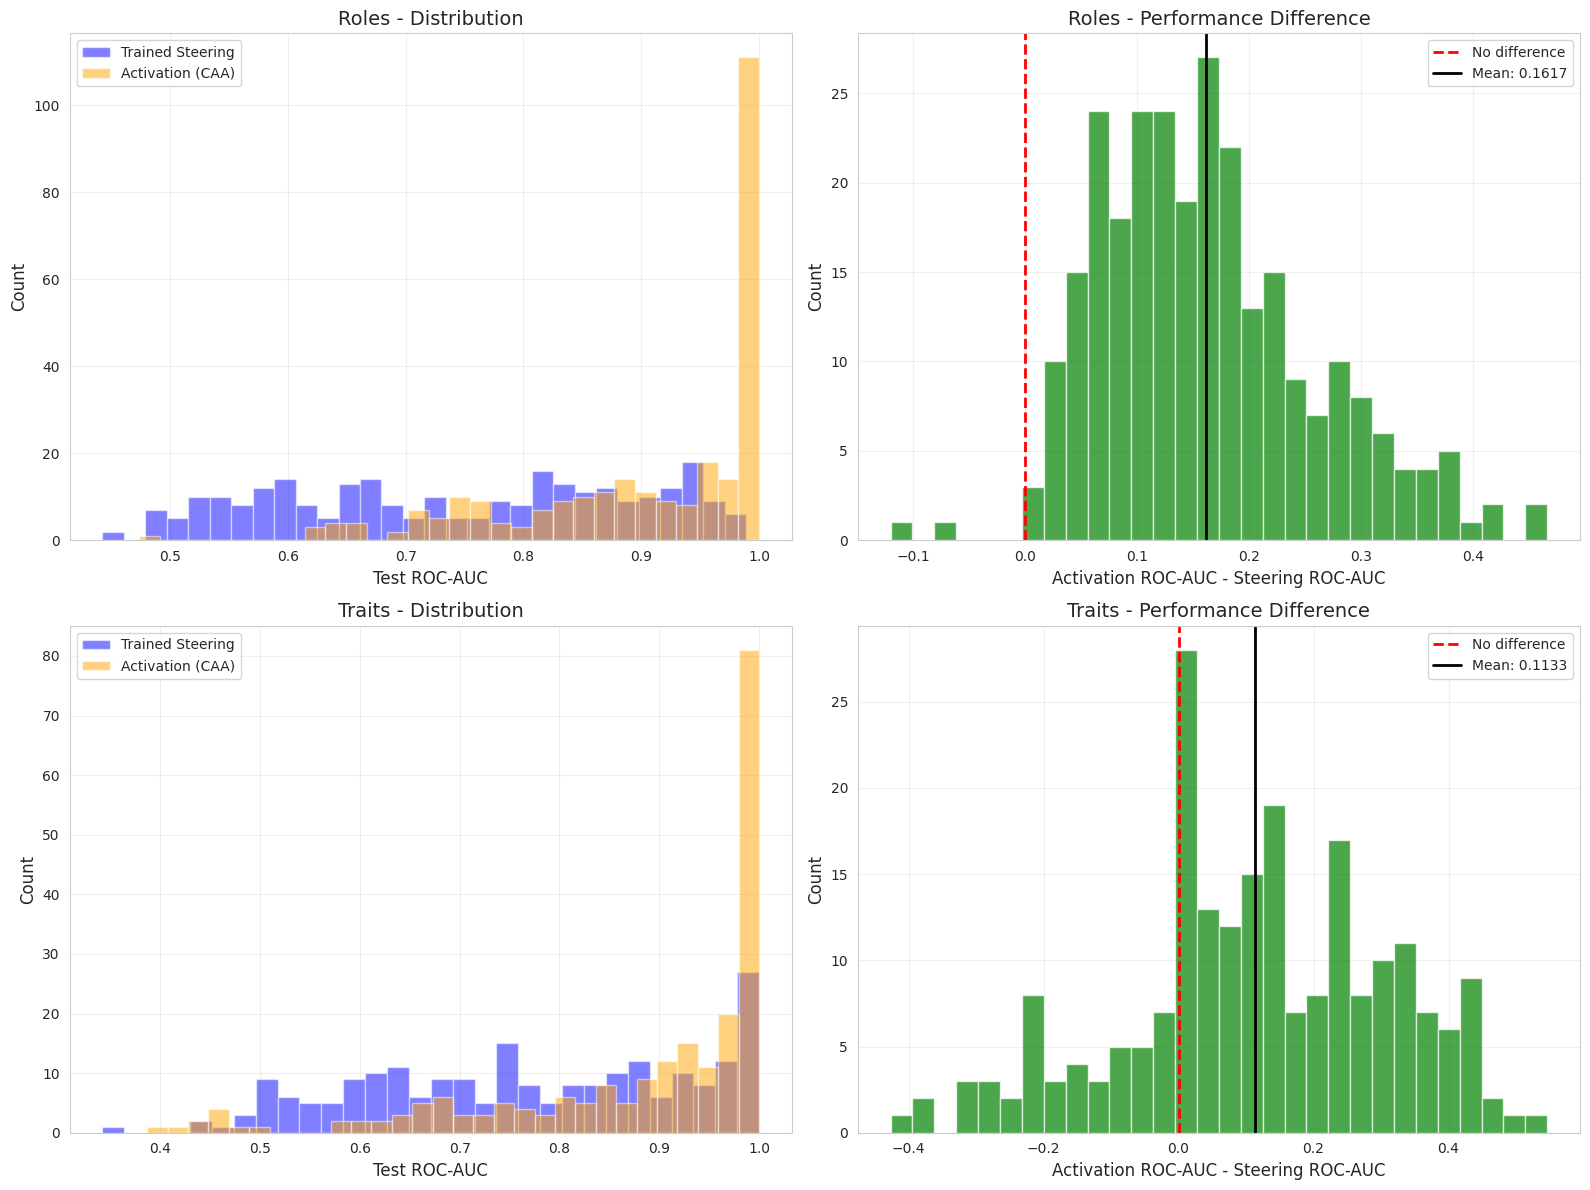

In [16]:
# Distribution comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for row_idx, dataset_type in enumerate(['role', 'trait']):
    subset = df_both[df_both['dataset_type'] == dataset_type]
    
    if len(subset) == 0:
        continue
    
    # Histograms
    ax = axes[row_idx, 0]
    ax.hist(subset['steering_test_roc_auc'], bins=30, alpha=0.5, 
            label='Trained Steering', color='blue')
    ax.hist(subset['activation_test_roc_auc'], bins=30, alpha=0.5, 
            label='Activation (CAA)', color='orange')
    ax.set_xlabel('Test ROC-AUC', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'{dataset_type.capitalize()}s - Distribution', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Difference histogram
    ax = axes[row_idx, 1]
    diff = subset['activation_test_roc_auc'] - subset['steering_test_roc_auc']
    ax.hist(diff, bins=30, alpha=0.7, color='green')
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='No difference')
    ax.axvline(diff.mean(), color='black', linestyle='-', linewidth=2, 
               label=f'Mean: {diff.mean():.4f}')
    ax.set_xlabel('Activation ROC-AUC - Steering ROC-AUC', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'{dataset_type.capitalize()}s - Performance Difference', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/workspace/steering_vs_activation_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

/tmp/ipykernel_2266920/3485486528.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(plot_data, labels=labels, patch_artist=True)


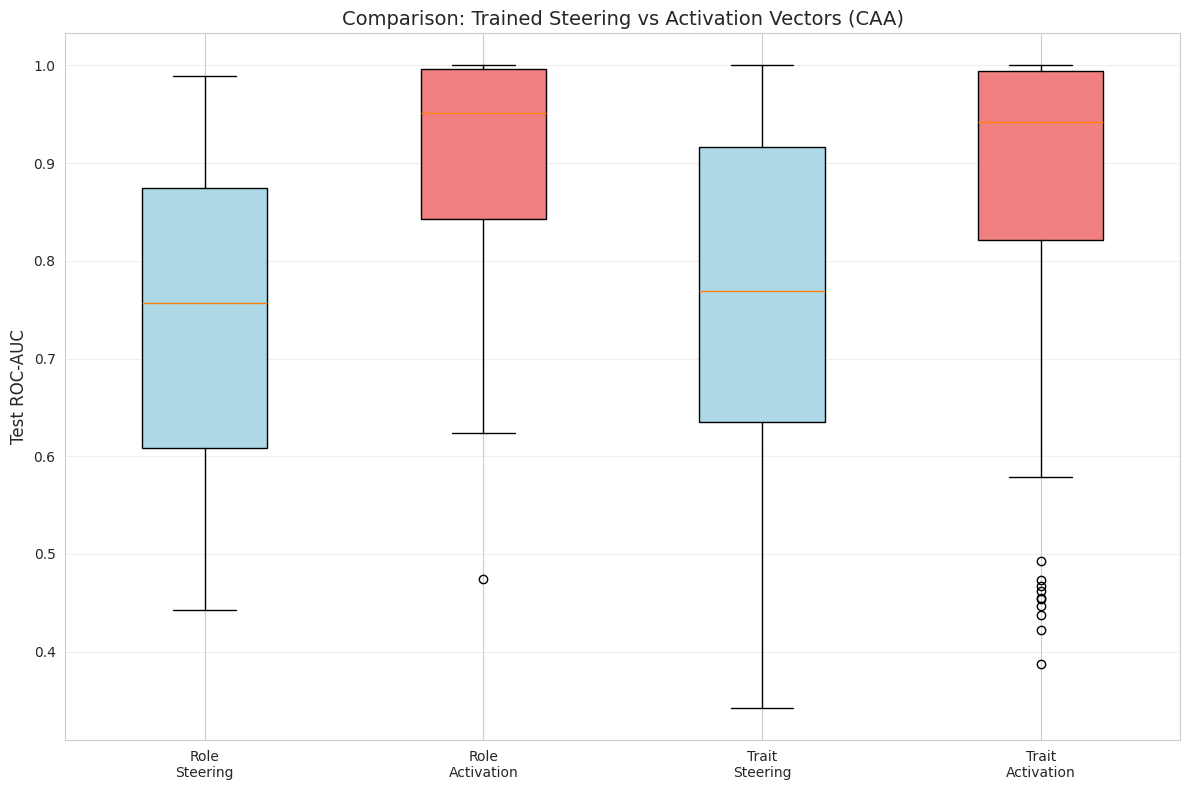

In [17]:
# Box plots for comparison
fig, ax = plt.subplots(figsize=(12, 8))

plot_data = []
labels = []

for dataset_type in ['role', 'trait']:
    subset = df_both[df_both['dataset_type'] == dataset_type]
    if len(subset) == 0:
        continue
        
    plot_data.append(subset['steering_test_roc_auc'].values)
    labels.append(f'{dataset_type.capitalize()}\nSteering')
    
    plot_data.append(subset['activation_test_roc_auc'].values)
    labels.append(f'{dataset_type.capitalize()}\nActivation')

bp = ax.boxplot(plot_data, labels=labels, patch_artist=True)

# Color the boxes
colors = ['lightblue', 'lightcoral'] * 2
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_ylabel('Test ROC-AUC', fontsize=12)
ax.set_title('Comparison: Trained Steering vs Activation Vectors (CAA)', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('/workspace/steering_vs_activation_boxplot.png', dpi=150, bbox_inches='tight')
plt.show()

## Top/Bottom Performers

In [18]:
# Calculate performance difference
df_both['diff'] = df_both['activation_test_roc_auc'] - df_both['steering_test_roc_auc']

print("Top 10: Activation vectors much better than trained steering")
print("=" * 80)
top10 = df_both.nlargest(10, 'diff')[['dataset', 'dataset_type', 
                                        'steering_test_roc_auc', 
                                        'activation_test_roc_auc', 'diff']]
print(top10.to_string(index=False))

print("\n\nTop 10: Trained steering better than activation vectors")
print("=" * 80)
bottom10 = df_both.nsmallest(10, 'diff')[['dataset', 'dataset_type',
                                           'steering_test_roc_auc',
                                           'activation_test_roc_auc', 'diff']]
print(bottom10.to_string(index=False))

Top 10: Activation vectors much better than trained steering
                          dataset dataset_type  steering_test_roc_auc  activation_test_roc_auc     diff
    qwen-3-32b__trait__methodical        trait               0.342274                 0.888455 0.546181
      qwen-3-32b__trait__reverent        trait               0.493472                 0.989392 0.495920
qwen-3-32b__trait__collectivistic        trait               0.462760                 0.935903 0.473142
           qwen-3-32b__role__hive         role               0.486667                 0.952667 0.466000
 qwen-3-32b__trait__deterministic        trait               0.528351                 0.987552 0.459201
         qwen-3-32b__role__infant         role               0.442667                 0.895943 0.453275
      qwen-3-32b__trait__abstract        trait               0.517517                 0.961701 0.444184
    qwen-3-32b__trait__idealistic        trait               0.496944                 0.935417 0.438472
   

## Train vs Test Performance

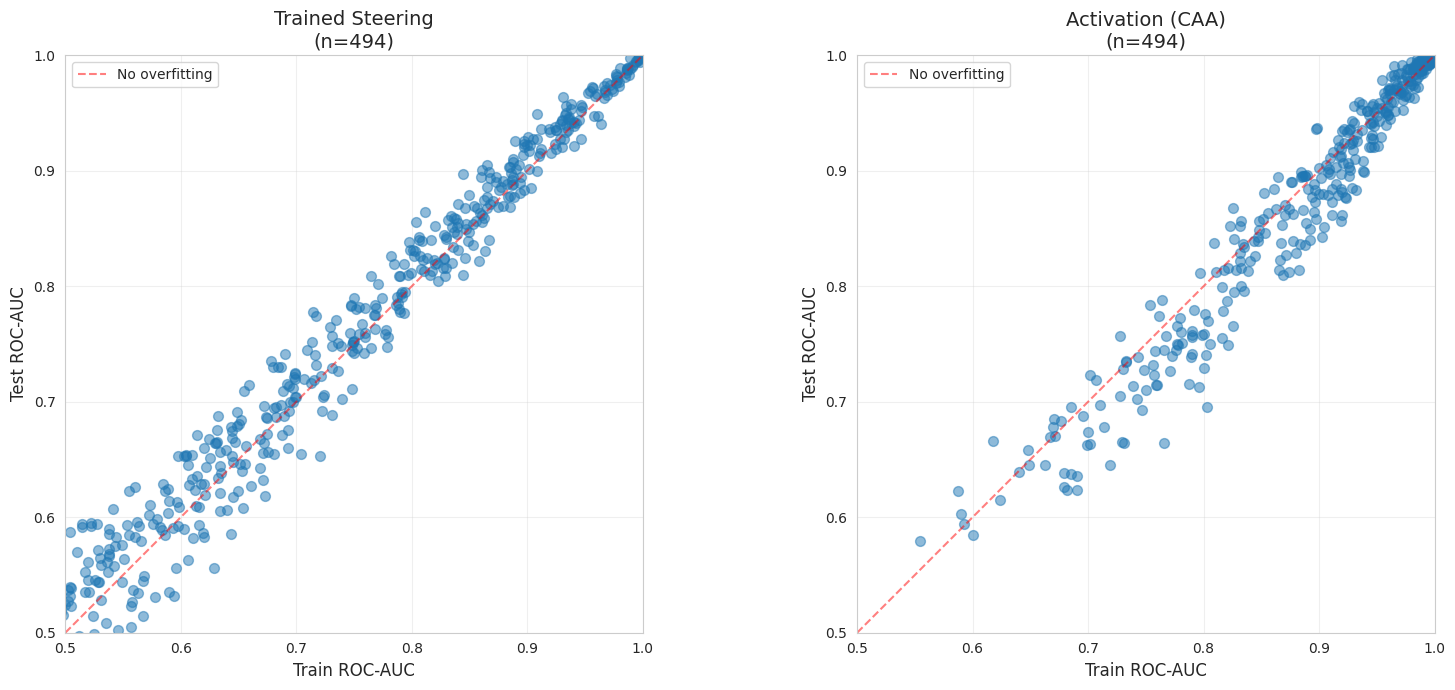

In [19]:
# Check for overfitting - compare train vs test
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for idx, method in enumerate([('steering', 'Trained Steering'), 
                               ('activation', 'Activation (CAA)')]):
    prefix, label = method
    ax = axes[idx]
    
    train_col = f'{prefix}_train_roc_auc'
    test_col = f'{prefix}_test_roc_auc'
    
    subset = df_both[[train_col, test_col]].dropna()
    
    ax.scatter(subset[train_col], subset[test_col], alpha=0.5, s=50)
    
    # Diagonal
    lims = [0.5, 1.0]
    ax.plot(lims, lims, 'r--', alpha=0.5, label='No overfitting')
    
    ax.set_xlabel('Train ROC-AUC', fontsize=12)
    ax.set_ylabel('Test ROC-AUC', fontsize=12)
    ax.set_title(f'{label}\n(n={len(subset)})', fontsize=14)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('/workspace/train_vs_test_overfitting.png', dpi=150, bbox_inches='tight')
plt.show()

## Export Summary Table

In [20]:
# Create summary table
summary = df_both.groupby('dataset_type').agg({
    'steering_test_roc_auc': ['mean', 'std', 'min', 'max'],
    'activation_test_roc_auc': ['mean', 'std', 'min', 'max'],
    'diff': ['mean', 'std']
}).round(4)

print("\nSummary Table:")
print(summary)

# Save to CSV
df_both.to_csv('/workspace/steering_vs_activation_comparison.csv', index=False)
print("\nFull comparison saved to: /workspace/steering_vs_activation_comparison.csv")


Summary Table:
             steering_test_roc_auc                          \
                              mean     std     min     max   
dataset_type                                                 
role                        0.7441  0.1485  0.4427  0.9891   
trait                       0.7696  0.1620  0.3423  1.0000   

             activation_test_roc_auc                        diff          
                                mean     std    min  max    mean     std  
dataset_type                                                              
role                          0.9058  0.1080  0.474  1.0  0.1617  0.0966  
trait                         0.8829  0.1469  0.387  1.0  0.1133  0.1961  

Full comparison saved to: /workspace/steering_vs_activation_comparison.csv
